In [1]:
from numpy import *; from numpy.core.records import fromarrays;from scipy.constants import *
from matplotlib.pyplot import *
import sys; sys.path.insert(0,'/home/noah/Desktop/large_analysis/ca_analysis/'); import os
import predefined as pd; import fileread as fr
import pickle
from scipy.signal import fftconvolve; from scipy.optimize import curve_fit
import time

def e_ratio(T):
    '''Gives m_e/E, where E=m+T is input in terms of keV'''
    e_mass=m_e*c**2./(kilo*eV)
    return 1./(1.+T/e_mass)

#### Reading in detector response pars

In [2]:
with open('/home/noah/Desktop/large_analysis/ca_analysis/detector_response/detector_response.pickle','rb') as f:
    detector_response=pickle.load(f)               #Loading det. repsp. widths (gaussian smearing)

#### Initializing simulation data

In [3]:
nbins,rang=1000,[0,800]
full_load=False

path='/home/noah/Desktop/large_analysis/zeck_simulation/BSG/'
b0=np.load(path+'b0.npy').view(np.recarray)                      # Reading in theoretical spectra for appropriate normalizations
b1=np.load(path+'b1.npy').view(np.recarray)                      # Reading in theoretical spectra for appropriate normalizations
alpha0,alpha1=np.sum(b0.Ne),np.sum(b1.Ne)


path='/home/noah/Desktop/large_analysis/zeck_simulation/ca_small_set/'
path='/home/noah/Desktop/large_analysis/zeck_simulation/45Ca_082019/'
if full_load==True:
    b0,b1=load(path+'45Ca_b0.npy'),load(path+'45Ca_b1.npy')               # Reading in 45Ca b=1 b=0 PENELOPE spectra
    b0,b1=pd.sim_restructure(b0),pd.sim_restructure(b1)                   # Restructuring the sim data
    b0,b1=b0.view(recarray),b1.view(recarray)                             # Making the spectra record arrays (easier)
    Fullb0,Fullb1=pd.sim_comb_single_pixel(b0),pd.sim_comb_single_pixel(b1)  #Perfect summed simulated spectra
    Fullb0,Fullb1=Fullb0.view(recarray),Fullb1.view(recarray)
    np.save(path+'Fullb0',Fullb0)
    np.save(path+'Fullb1',Fullb1)
else:
    Fullb0,Fullb1=np.load(path+'Fullb0.npy').view(np.recarray),np.load(path+'Fullb1.npy').view(np.recarray)
print(Fullb0.dtype)
Fullb0_hist=histogram(Fullb0.energy,bins=nbins,range=rang)[0]
Fullb1_hist=histogram(Fullb1.energy,bins=nbins,range=rang)[0]
Norm_b0 = 1./np.sum(Fullb0_hist)        # This is used later when taking difference of b=1 and b=0 spectra
Norm_b1 = 1./np.sum(Fullb1_hist)        # This is used later when taking difference of b=1 and b=0 spectra

(numpy.record, [('entry', '<i4'), ('board', '<i4'), ('channel', '<i4'), ('timestamp', '<f4'), ('energy', '<f4')])


#### Making simulated single pixel spectra & Smearing
Note: the smearing is done here. E-->E+deltaE, where deltaE=np.random.normal(loc=0,scale=sigma)

In [4]:
thresh=200                     # in ADC
coinc_window=400e-9
bdchs=[17,41]                            #In this routine, we're removing any events that hit 77W/E
# bdchs=[11]                            #This includes 52,64,65W and 64E
if full_load==True:
    truth0,truth1=np.zeros(len(b0),dtype=bool),np.zeros(len(b1),dtype=bool)
    for bdch in bdchs:                     #Taking sim events ONLY for bdchs
        bd,ch=int(bdch/8),int(bdch%8)
        truth0+=np.logical_not((b0.board==bd)*(b0.channel==ch))
        truth1+=np.logical_not((b1.board==bd)*(b1.channel==ch))
    sb0,sb1=b0[truth0],b1[truth1]
    sb0,sb1=sb0.view(np.recarray),sb1.view(np.recarray)


    bdchs=[6,11,12,35,36]
    for bdch in bdchs:
        bd,ch=int(bdch/8),int(bdch%8)
        sigma=detector_response[bdch]                 # Detector response for bd,ch
        trutharray=(sb0.board==bd)*(sb0.channel==ch)  # events in sb0= with bd ch
        sb0.energy[trutharray] += np.random.normal(loc=0,scale=sigma,size=np.sum(trutharray))
        trutharray=(sb1.board==bd)*(sb1.channel==ch)  # events in sb0= with bd ch
        sb1.energy[trutharray] += np.random.normal(loc=0,scale=sigma,size=np.sum(trutharray))

    sb0=sb0[sb0.energy>thresh/6.2]                          #Applying threshold cut to sim
    sb1=sb1[sb1.energy>thresh/6.2]                    #Applying threshold cut to sim

    sb0=pd.sim_sing_pix_coinc(sb0,coinc_window) #Summing events within a coinc_window timewindow
    sb0=sb0[pd.sim_single_event(sb0)]           # Making single pixel sim spectra
    sb1=pd.sim_sing_pix_coinc(sb1,coinc_window) #Summing events within a coinc_window timewindow
    sb1=sb1[pd.sim_single_event(sb1)]           # Making single pixel sim spectra
else:
    sb0,sb1=np.load(path+'sb0.npy').view(np.recarray),np.load(path+'sb1.npy').view(np.recarray)

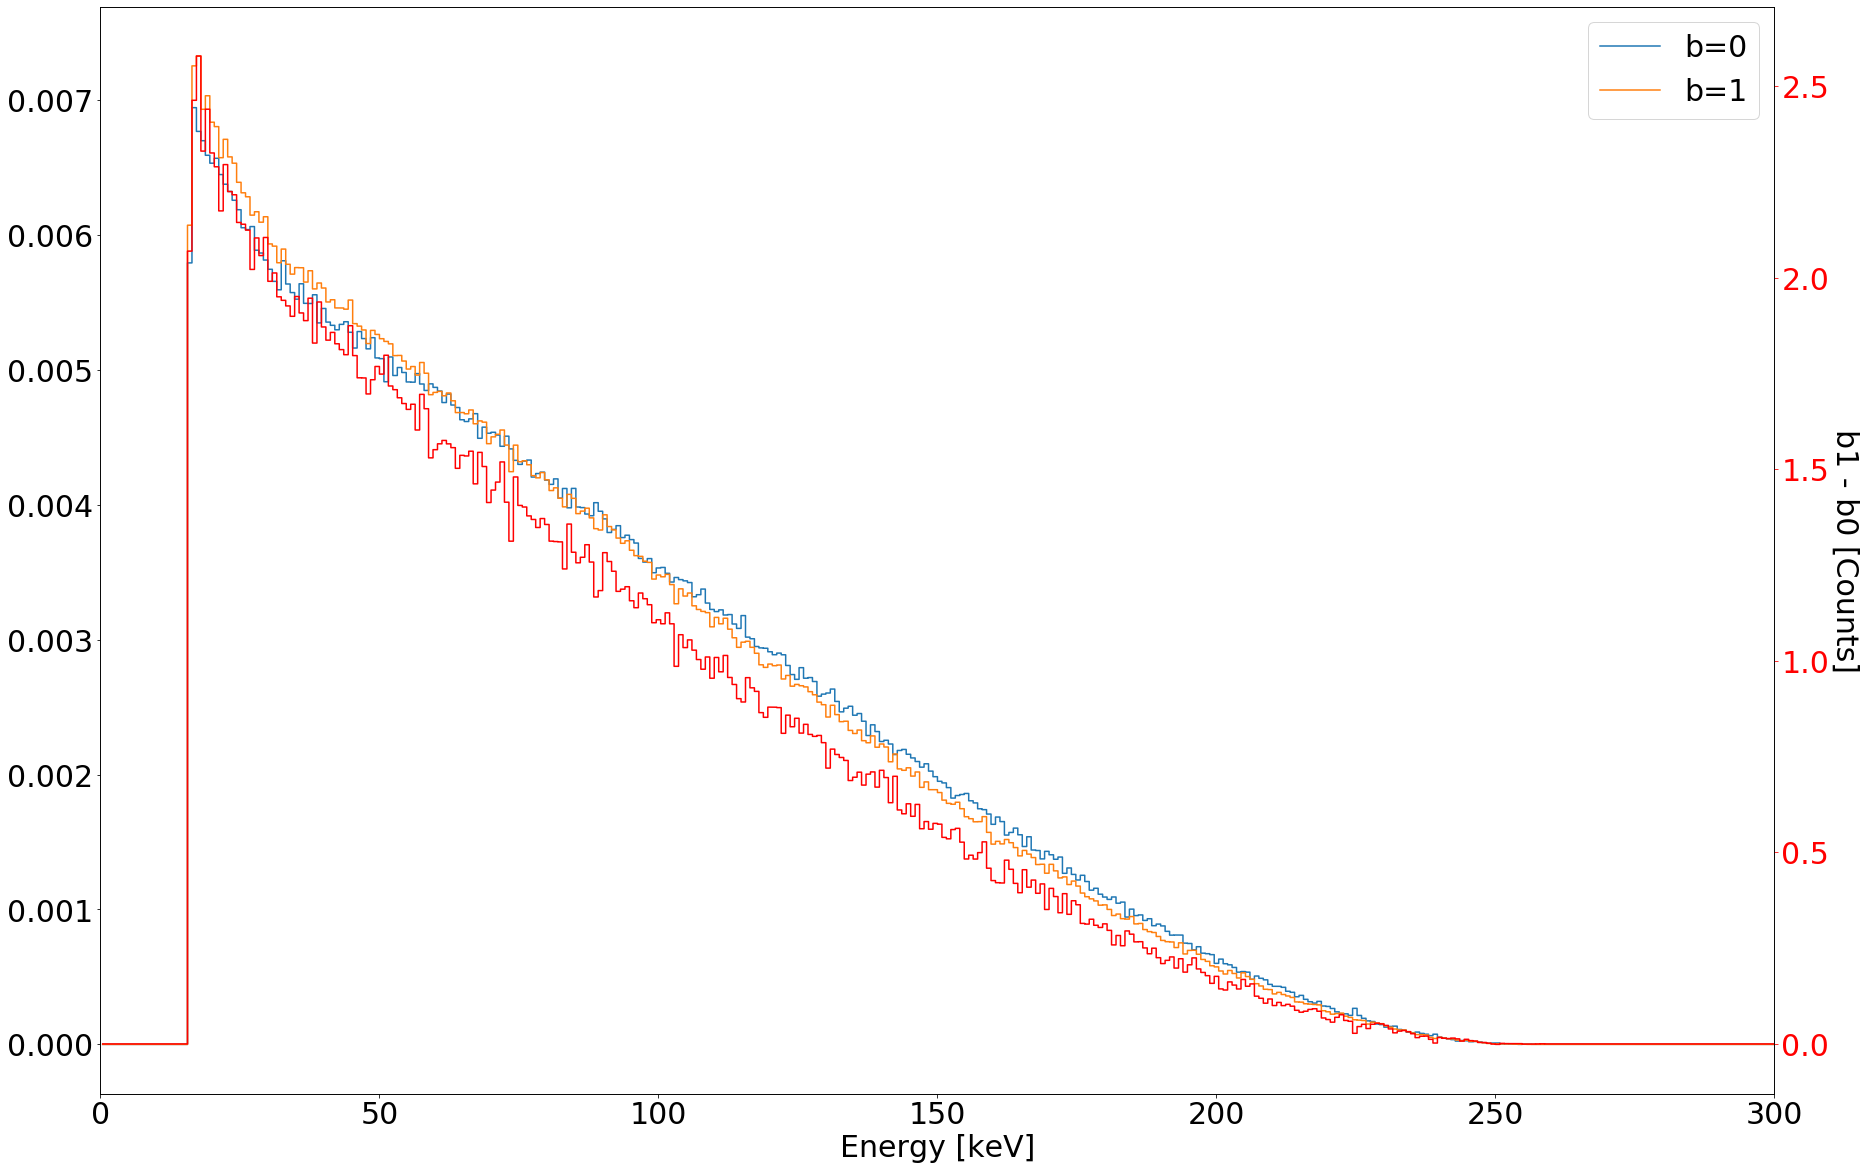

In [5]:
fs=30
fig,ax=subplots(figsize=(30,20))
temph0,tempb=np.histogram(sb0.energy,bins=1000,range=[0,800])
temph1,tempb=np.histogram(sb1.energy,bins=1000,range=[0,800])
temph0,temph1=temph0.astype(float),temph1.astype(float)
tempb=pd.cbins(tempb)
temph0*=Norm_b0
temph1*=Norm_b1

ax.plot(tempb,temph0,ds='steps',label='b=0')
ax.plot(tempb,temph1,ds='steps',label='b=1')
# temph1*=Norm_b
ax.tick_params(labelsize=fs)
ax.set_xlabel('Energy [keV]',fontsize=fs)
ax1=twinx()
ax1.plot(tempb,alpha1*temph1-alpha0*temph0,ds='steps',c='r')
ax1.tick_params(labelsize=fs,colors='r')
ax.set_xlabel('Energy [keV]',fontsize=fs)
ax.legend(fontsize=fs)
ax1.set_ylabel('b1 - b0 [Counts]',fontsize=fs,rotation=270,labelpad=30)
# ax1.set_ylim(-400,400)
ax.set_xlim(0,300)
show()
del tempb,temph0,temph1

#### Making simulated single pixel histograms with smearing

#### Fitting simulation to data
$$N\left(w(b=0)+b\left[w(b=1)-w(b=0)\right]\right)$$

Sliding window (constant fit length)

In [5]:
b0_hist,bins=histogram([],bins=nbins,range=rang)   #b0 single pixel histogram
b1_hist,bins=histogram([],bins=nbins,range=rang)   #b1 single pixel histogram
b0_hist,b1_hist=b0_hist.astype(float),b1_hist.astype(float)
bins=pd.cbins(bins)

# bdchs_of_interest=bdchs

bdchs_of_interest=[35]
for bdch in bdchs_of_interest:             # Looping over bdchs to smear sim pixel-by-pixel
    bd,ch=int(bdch/8),int(bdch%8)
    trutharray=(sb0.board==bd)*(sb0.channel==ch)  # events in sb0= with bd ch
    b0_hist+=histogram(sb0.energy[trutharray],bins=nbins,range=rang)[0]
    
    trutharray=(sb1.board==bd)*(sb1.channel==ch)  # events in sb1= with bd ch
    b1_hist+=histogram(sb1.energy[trutharray],bins=nbins,range=rang)[0]
print(np.sum(b0_hist),np.sum(b1_hist))
b0_hist*=Norm_b0
b1_hist*=Norm_b1                            # Normalizing the total number of counts in b1 to that of b1
# b0_hist*=1./np.sum(b0_hist)
# b1_hist*=1./np.sum(b1_hist)                            # Normalizing the total number of counts in b1 to that of b1

3389087.0 3266423.0


In [6]:
tr=200
d=load('uncal-thresh-'+str(tr)+'ADC.npy')        # Edit this once combine_all...ipynb finishes This file has all runs stored in it

d=d.view(recarray)
trutharray=np.zeros(len(d),dtype=bool)
for bdch in bdchs_of_interest:
    bd,ch=int(bdch/8),int(bdch%8)
    trutharray+=(d.board==bd)*(d.channel==ch)
osc_amp = 50                            # All WF with an oscillation amp less than osc_amp are included
trutharray *= np.sqrt(np.sum(d.osc_amps[:,0:2]**2.,axis=1)) < osc_amp  #OSCILLATION CUT
d=d[trutharray]


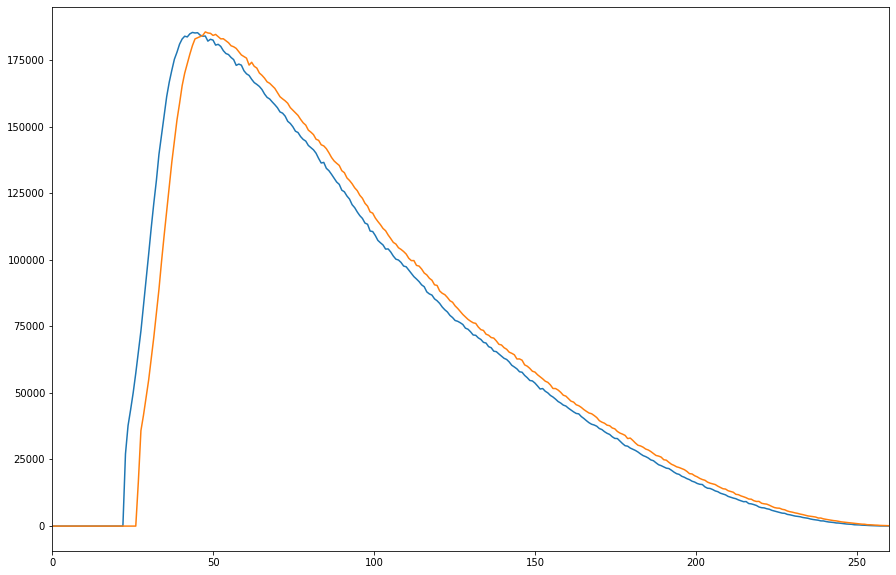

In [39]:
bd,ch=divmod(bdchs_of_interest[0],8)
t=(pd.calibration.board==bd)*(pd.calibration.channel==ch)
cal=pd.calibration[t]
offset=cal.offset
slope=cal.slope
slope_err=cal.slope_err
off_err=cal.off_err

rand_off=np.random.normal(scale=off_err)
rand_slope=np.random.normal(scale=slope_err)



fig,ax=subplots(figsize=(15,10))
d_hist=histogram((d.energy-offset)/(slope)\
                 ,bins=nbins,range=rang)[0]
ax.plot(bins,d_hist)
d_hist=histogram((d.energy-offset+rand_off)/(slope+rand_slope)\
                 ,bins=nbins,range=rang)[0]
ax.plot(bins,d_hist)
ax.set_xlim(0,260)
show()

In [7]:

b_vals=ndarray(shape=(0,7))    # b | b error | N | N error | X^2/DoF | begin. fit| end fit
stepsize=0
end=220
steps=arange(100,end-10,2)
true_bs=[]
true_b_err=[]

beg_bad,end_bad=100,100


minb=np.zeros(len(steps))
maxb=np.zeros(len(steps))
b=np.zeros(shape=(len(steps),0))
temps=np.zeros(len(steps))
bd,ch=divmod(bdchs_of_interest[0],8)
t=(pd.calibration.board==bd)*(pd.calibration.channel==ch)
cal=pd.calibration[t]
offset=cal.offset
slope=cal.slope
slope_err=cal.slope_err
off_err=cal.off_err

n=1000
for j in range(n):
    if j%100==0:
        print('\r'+50*' ',end='')
        print('\r'+'{:0d} percent complete'.format(int(j/n*100)),end='')
    rand_off=np.random.normal(scale=off_err)
    rand_slope=np.random.normal(scale=slope_err)
    d_hist=histogram((d.energy-offset+rand_off)/(slope+rand_slope)\
                     ,bins=nbins,range=rang)[0]
    
    for i,beg in enumerate(steps):
        if beg > end_bad:
            trutharray = ((bins>beg)*(bins<end))  # Trutharray for fit window
        else:
            trutharray = ((bins>beg)*(bins<beg_bad))+((bins>end_bad)*(bins<end))  # Trutharray for fit window

        weights=np.sqrt(d_hist[trutharray])
        X=(trutharray,alpha0*b0_hist,alpha1*b1_hist)   # Independent values for curve_fit

        pars,vrs=curve_fit(pd.fierz_fit,X,d_hist[trutharray],\
                          p0=[d_hist[trutharray][0],0],sigma=weights,\
                           absolute_sigma=False,maxfev=1000000,ftol=1e-8)
    #                       epsfcn=1e-9)

        vrs=sqrt(diag(vrs))           #Sqrt of cov. mtx = errors

        chisq=np.sum((d_hist[trutharray]-pd.fierz_fit(X,*pars))**2./d_hist[trutharray])/(np.sum(trutharray)-len(pars))
        out=np.asarray([pars[1],vrs[1],pars[0],vrs[0],chisq,beg,end])
        b_vals=vstack((b_vals,out))
        temps[i]=pars[1]
    b=np.hstack((b,temps[:,None]))
names='b,b_error,N,N_error,chisq,beg,end'
formats='f8,f8,f8,f8,f8,f8,f8'
b_vals=fromarrays(b_vals.T,names=names,formats=formats) # Converting to recarray for utility
b_vals=b_vals.view(recarray)
del names,formats
print('Done')

90 percent complete                               Done


In [16]:
c=b.copy()
for i in range(c.shape[0]):
    c[i,:][c[i,:]>10]=np.nan

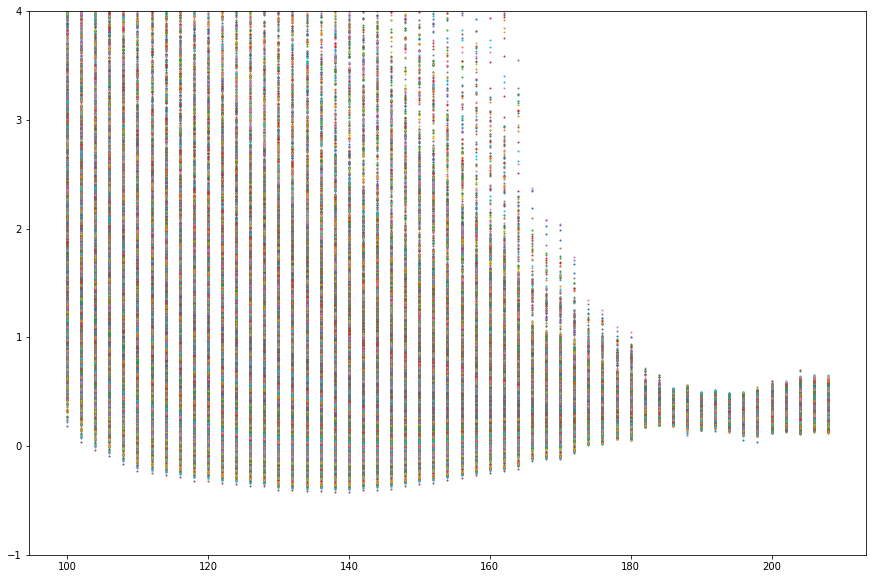

In [17]:
fig,ax=subplots(nrows=1,ncols=1,figsize=(15,10))
for i in range(b.shape[1]):
    ax.plot(steps,c[:,i],'o',ms=1)
# ax.set_xlim(130,140)
ax.set_ylim(-1,4)
show()

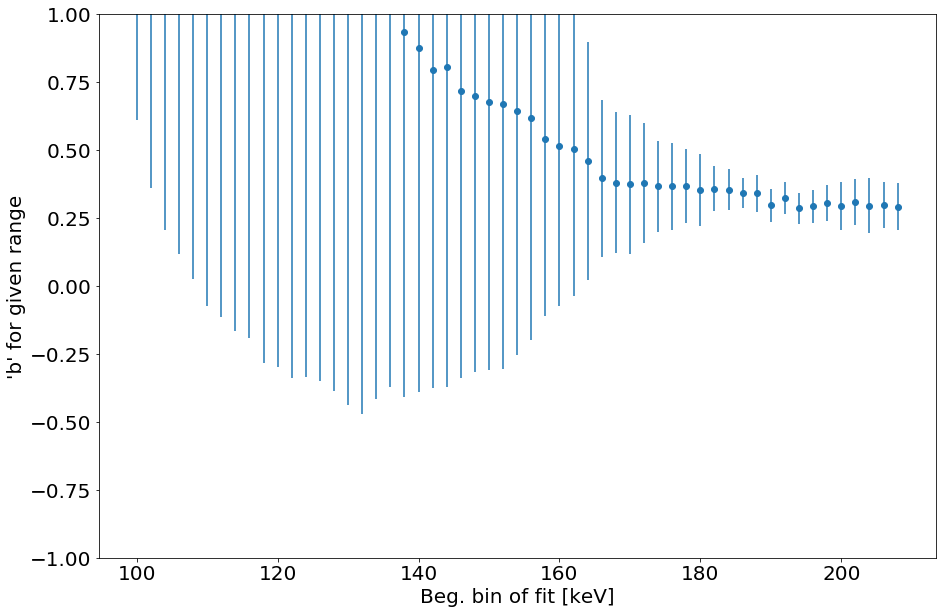

In [18]:
fs=20
fig,ax=subplots(nrows=1,ncols=1,figsize=(15,10))
mean=np.nanmean(c,axis=1)
sigma=np.nanstd(c,axis=1)
ax.errorbar(steps,mean,sigma,fmt='o')
ax.set_ylim(-1,1)
ax.set_ylabel('\'b\' for given range',fontsize=fs)
ax.set_xlabel('Beg. bin of fit [keV]',fontsize=fs)
ax.tick_params(labelsize=fs)
show()

0.6752813788471853 0.9852796098666854


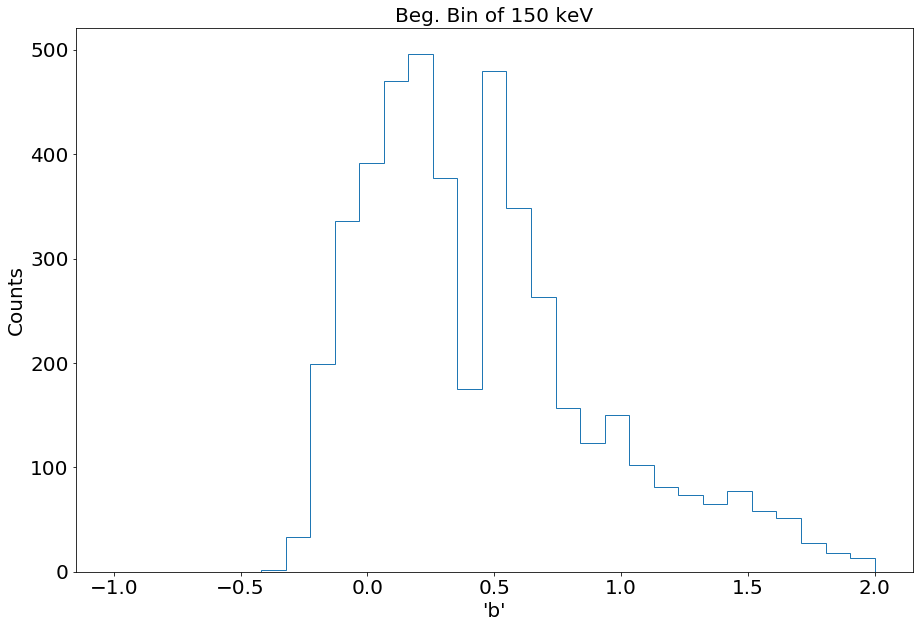

In [20]:
fs=20
fig,ax=subplots(nrows=1,ncols=1,figsize=(15,10))
t=150
t=np.nonzero(steps==t)[0][0]
print(np.nanmean(c[t,:]),np.nanstd(c[t,:]))
h,b,ax.hist(c[t,:],bins=31,range=[-1,2],histtype='step')
# ax.set_ylim(0,1)
ax.set_ylabel('Counts',fontsize=fs)
ax.set_xlabel('\'b\'',fontsize=fs)
ax.set_title('Beg. Bin of {:0d} keV'.format(steps[t]),fontsize=fs)
ax.tick_params(labelsize=fs)
show()